In [188]:
from fktools import *

import tensorflow as tf

from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import CDKMRippleCarryAdder, ModularAdderGate
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeVigoV2

import networkx as nx

import math

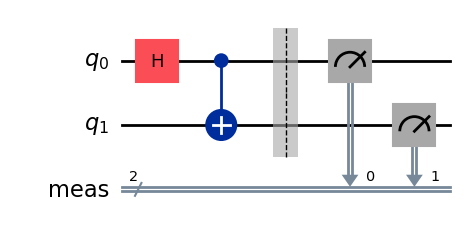

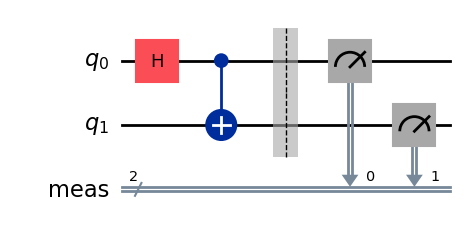

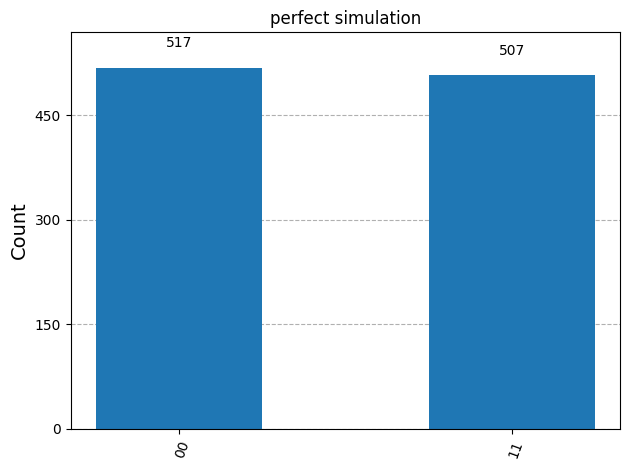

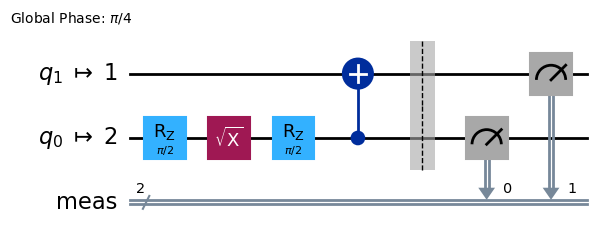

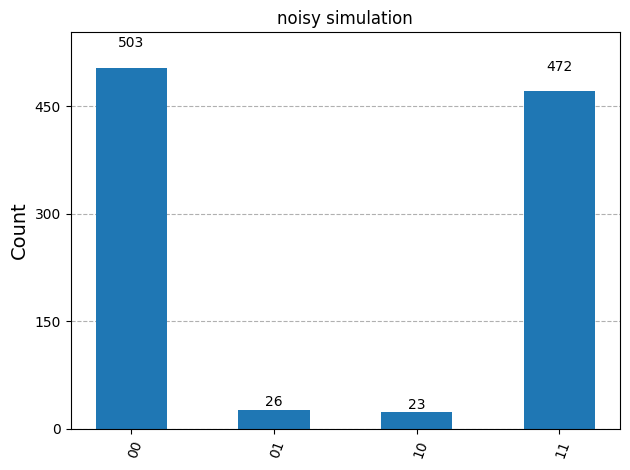

In [189]:
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()

display(circ.draw('mpl'))


sim_ideal = AerSimulator()

tcirc = transpile(circ, sim_ideal)

result = sim_ideal.run(tcirc).result()
counts = result.get_counts(0)

display(tcirc.draw('mpl'))
display(plot_histogram(counts, title="perfect simulation"))



device_backend = FakeVigoV2()
sim_vigo = AerSimulator.from_backend(device_backend)

tcirc = transpile(circ, sim_vigo)

result_noise = sim_vigo.run(tcirc).result()
counts_noise = result_noise.get_counts(0)

display(tcirc.draw('mpl'))
display(plot_histogram(counts_noise, title="noisy simulation"))


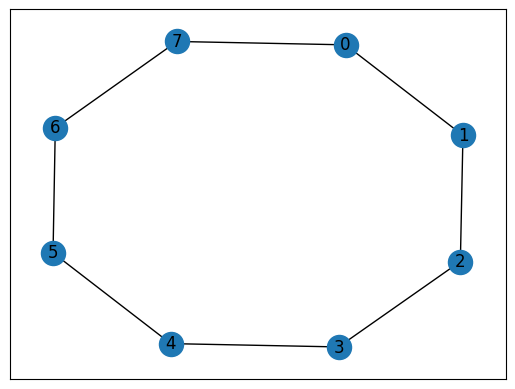

In [190]:
nodes = 2**3

G = nx.Graph()

G.add_nodes_from(np.arange(nodes).tolist())
G.add_edges_from([(i, (i+1)%nodes) for i in range(nodes)])
nx.draw_networkx(G)

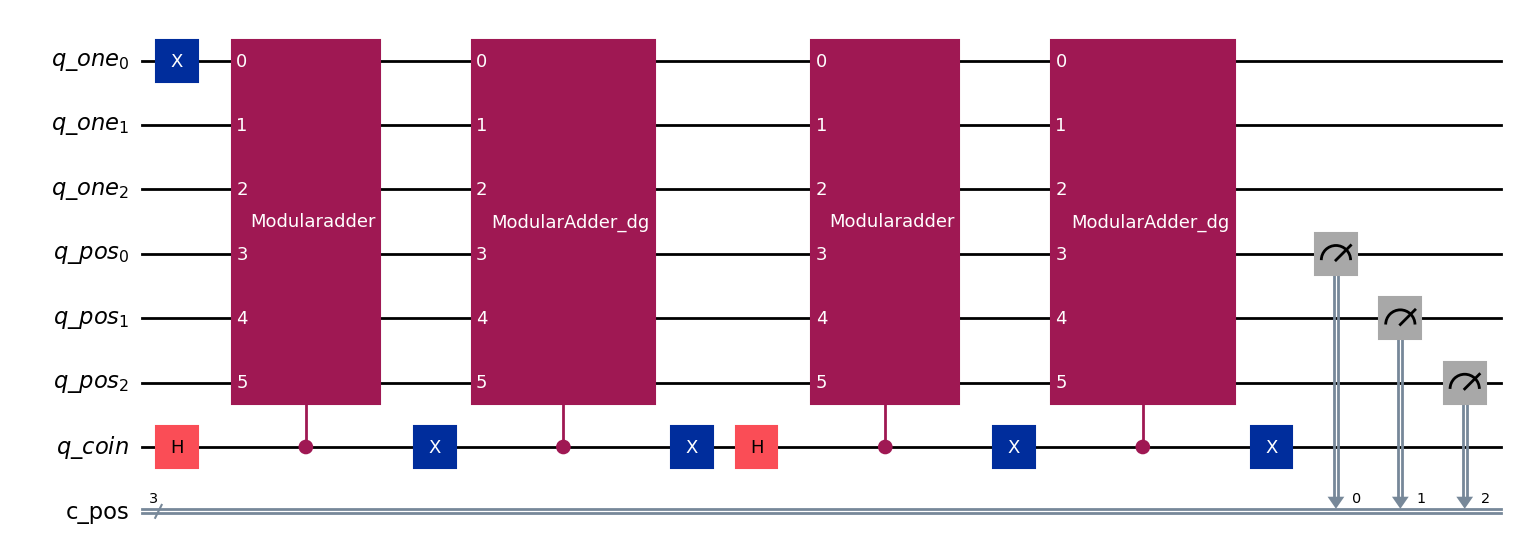

In [210]:
nodes_power = 3
num_steps = 2


q_pos = QuantumRegister(nodes_power, "q_pos")
q_one = QuantumRegister(nodes_power, "q_one")  
q_coin = QuantumRegister(1, "q_coin") 
c_pos = ClassicalRegister(nodes_power, "c_pos")
regs = [q_one, q_pos, q_coin, c_pos]


ControlledModularAdder = ModularAdderGate(num_state_qubits=nodes_power).control(num_ctrl_qubits=1)

qc = QuantumCircuit(*regs)

qc.x(q_one[0])


for _ in range(num_steps):

    qc.h(q_coin)

    qc.append(ControlledModularAdder, [q_coin, *q_one, *q_pos])

    qc.x(q_coin)
    qc.append(ControlledModularAdder.inverse(), [q_coin, *q_one, *q_pos])
    qc.x(q_coin)


qc.measure(q_pos, c_pos)

display(qc.draw('mpl'))

<BarContainer object of 8 artists>

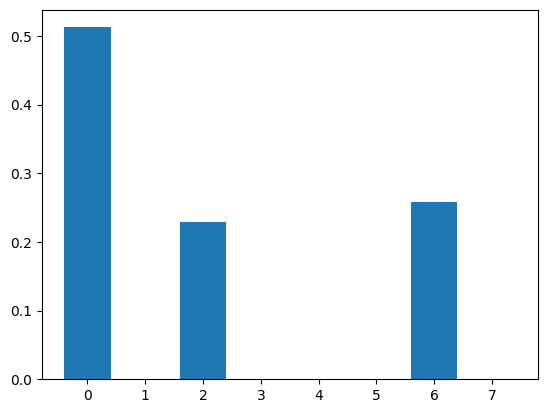

In [211]:
sim_ideal = AerSimulator()

tcirc = transpile(qc, sim_ideal)

result = sim_ideal.run(tcirc).result()
counts = result.get_counts(0)

# display(plot_histogram(counts, title="perfect simulation"))

probs = np.zeros(shape=(2**nodes_power), dtype=np.float32)

for key in counts.keys():
    probs[int(key, 2)] = counts[key]
probs /= np.sum(probs)
plt.bar(np.arange(2**nodes_power), probs)